# Phase 4 Project

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [62]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [63]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [64]:
df.shape

(9093, 3)

In [65]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [66]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [68]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [69]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [70]:
df['text']=df['tweet_text']

In [71]:
df.drop('tweet_text',axis=1, inplace=True)

In [72]:
df.head()

,emotion_in_tweet_is_directed_at,target,text
0,iPhone,Negative emotion,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,iPad or iPhone App,Positive emotion,@jessedee Know about @fludapp ? Awesome iPad/i...
2,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. The...
3,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as cra...
4,Google,Positive emotion,@sxtxstate great stuff on Fri #SXSW: Marissa M...


__Drop Duplicates__

In [76]:
df.duplicated().sum()

22

In [77]:
df.drop_duplicates(inplace=True)

In [78]:
df.shape

(9071, 3)

__Train-Test Split__

In [128]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'], 
                                                    random_state=42,
                                                    stratify=df['target'])

In [129]:
X_train.shape

(6803,)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [130]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [131]:
df_train.head()

,text,target
2590,Off to see @mention in &quot;Left Brain Search...,Positive emotion
676,google is interested in location based tech fo...,Negative emotion
1132,Attending the @mention party at #SXSW with som...,No emotion toward brand or product
4882,Anyone who was going to buy a new iPad should ...,I can't tell
8576,There is totally a make-shift Apple store down...,No emotion toward brand or product


In [132]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [133]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [134]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [137]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [139]:
df_test_clean.head()

,text,target
5038,RT @mention : Aron Pilhofer from The New York ...,0
642,"Honestly, I think everyone at #sxsw owns an @m...",0
5992,RT @mention Here's Google Realtime for #SXSW {...,2
8293,In line at the temp apple store at #sxsw!! Got...,2
6746,RT @mention The iPad 2 Takes Over #SXSW [#VIDE...,2


In [34]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['tweet_text'].values.astype('U'))
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


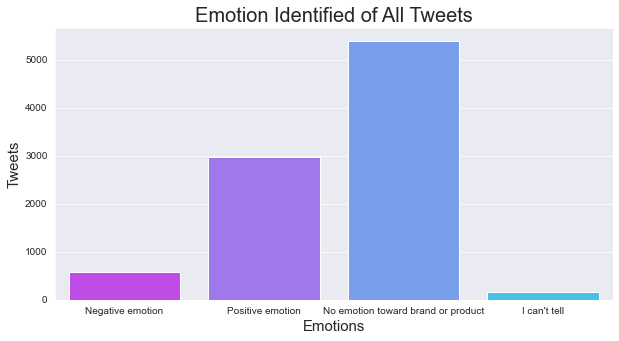

In [50]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(df['is_there_an_emotion_directed_at_a_brand_or_product'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
plt.show()

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


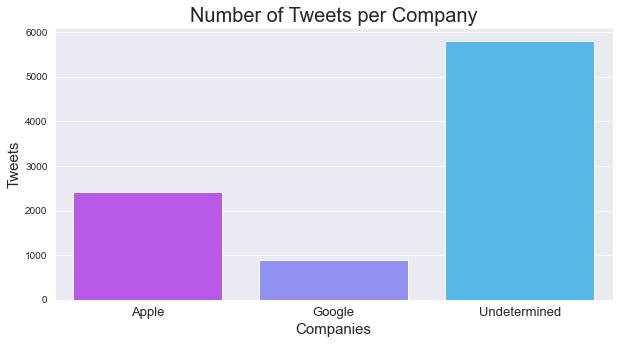

In [48]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Neither'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

## Metrics